In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Importing necessary libraries

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

# Loading the data

In [3]:

train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Taking a look at the features

In [4]:
y_train = train['label'].astype('float32')
X_train = train.drop(['label'], axis=1).astype('int32')
X_test = test.astype('float32')
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

Text(0, 0.5, 'Count')

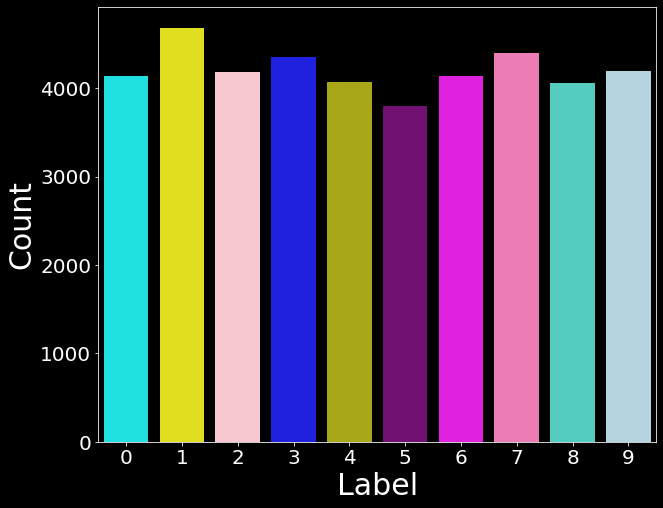

In [23]:
plt.style.use('dark_background')
plt.figure(figsize=(10,8))
plt.xticks(size=20)
plt.yticks(size=20)

x = sns.countplot(x='label', data=train,palette=['cyan','yellow','pink','b','y','purple','magenta','hotpink','turquoise','lightblue']);
x.set_xlabel("Label",fontsize=30)
x.set_ylabel('Count',fontsize=30)
#sns.plt.show()

# Data normalization

In [24]:
X_train = X_train/255
X_test = X_test/255

In [25]:

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
X_train.shape, X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

# One-hot encoding

In [26]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 10)
y_train.shape

(42000, 10)

In [27]:
print(train['label'].head())
y_train[0:5,:]

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Splitting the data

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

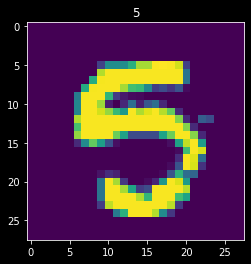

In [29]:

plt.imshow(X_train[1][:,:,0])
plt.title(y_train[1].argmax());

# Importing DL libraries

In [30]:
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
import keras
from keras import backend as K

# Building a CNN

In [31]:
# Building a CNN model
input_shape = (28,28,1)
X_input = Input(input_shape)

# layer 1
x = Conv2D(64,(3,3),strides=(1,1),name='layer_conv1',padding='same')(X_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool1')(x)
# layer 2
x = Conv2D(32,(3,3),strides=(1,1),name='layer_conv2',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool2')(x)
# layer 3
x = Conv2D(32,(3,3),strides=(1,1),name='conv3',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2), name='maxPool3')(x)
# fc
x = Flatten()(x)
x = Dense(64,activation ='relu',name='fc0')(x)
x = Dropout(0.25)(x)
x = Dense(32,activation ='relu',name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(10,activation ='softmax',name='fc2')(x)

conv_model = Model(inputs=X_input, outputs=x, name='Predict')
conv_model.summary()

Model: "Predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
maxPool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128 

# Note :
In SGD 30 epochs is a reasonable choice to use although it takes a long time to compute.
Adam optimizer converges quicker. Use one of the following optimizers.

# Using Adam

In [32]:
# Adam optimizer
conv_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
conv_model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_cv,y_cv))

Epoch 1/10
378/378 [==============================] - 6s 6ms/step - loss: 0.9753 - accuracy: 0.6716 - val_loss: 0.7760 - val_accuracy: 0.7486
Epoch 2/10
378/378 [==============================] - 2s 5ms/step - loss: 0.1470 - accuracy: 0.9579 - val_loss: 0.0719 - val_accuracy: 0.9783
Epoch 3/10
378/378 [==============================] - 2s 5ms/step - loss: 0.1027 - accuracy: 0.9731 - val_loss: 0.0724 - val_accuracy: 0.9805
Epoch 4/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0792 - accuracy: 0.9789 - val_loss: 0.0504 - val_accuracy: 0.9850
Epoch 5/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0628 - accuracy: 0.9826 - val_loss: 0.0544 - val_accuracy: 0.9843
Epoch 6/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0525 - accuracy: 0.9858 - val_loss: 0.0434 - val_accuracy: 0.9869
Epoch 7/10
378/378 [==============================] - 2s 5ms/step - loss: 0.0503 - accuracy: 0.9862 - val_loss: 0.0556 - val_accuracy: 0.9874
Epoch 

# Using SGD

In [33]:

# SGD optimizer
sgd = SGD(lr=0.0005, momentum=0.5, decay=0.0, nesterov=False) 
conv_model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
conv_model.fit(X_train, y_train, epochs=30, validation_data=(X_cv, y_cv))


Epoch 1/30
1182/1182 [==============================] - 6s 4ms/step - loss: 0.0322 - accuracy: 0.9919 - val_loss: 0.0332 - val_accuracy: 0.9914
Epoch 2/30
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0236 - accuracy: 0.9932 - val_loss: 0.0318 - val_accuracy: 0.9919
Epoch 3/30
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0210 - accuracy: 0.9939 - val_loss: 0.0316 - val_accuracy: 0.9914
Epoch 4/30
1182/1182 [==============================] - 4s 4ms/step - loss: 0.0242 - accuracy: 0.9934 - val_loss: 0.0313 - val_accuracy: 0.9919
Epoch 5/30
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0203 - accuracy: 0.9946 - val_loss: 0.0312 - val_accuracy: 0.9917
Epoch 6/30
1182/1182 [==============================] - 4s 4ms/step - loss: 0.0207 - accuracy: 0.9948 - val_loss: 0.0305 - val_accuracy: 0.9919
Epoch 7/30
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0182 - accuracy: 0.9947 - val_loss: 0.0305 - val_accuracy:

In [34]:

y_pred = conv_model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
my_submission = pd.DataFrame({'ImageId': list(range(1, len(y_pred)+1)), 'Label': y_pred})
my_submission.to_csv('submission.csv', index=False)


# Test Accuracy
Adam optimizer (10 epochs, batch size = 100) : 0.98985<br>
SGD optimizer (12 epochs) : 0.97600